# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Fuerteventura

En este estudio se analiza la evolución de la pandemia de COVID-19 en la isla de Fuerteventura y la influencia de factores como los atmosféricas en la evolución de dicha enfermedad. Para este fin se utiliza el modelo ARIMA tanto univariable como multivariable. 

El estudio se fragmenta en 4 partes:
* modelado univariable donde se emplea únicamente la variable objetivo.
* modelado multivariable empleando las variables pandémicas. Dichas variables son:
    * pcr_total: Número total de pruebas PCR realizadas.
    * Urg_cv: Ingresos en el servicio de urgencias por COVID19.
    * HPT_cv19: Ocupación del resto de camas para pacientes COVID.
    * CCR_cv19: Ocupación de las unidades críticas con respirador para pacientes COVID.
* modelado multivariable empleando las variables atmosféricas:
    * tmin: Temperatura mínima diaria.    
    * tmed: Temperatura media diaria.  
    * presMax: Presión máxima al nivel de la estación.   
* modelado multivariable con todas las variables.

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    ''' Visualiza el gráfico STL con la descomposición en tendencia, estacionalidad y residuos de la serie temporal
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación parcial de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    ''' Obtiene la diferencia entre los valores de test y los predichos
    
    Args:
        test (Serie): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

Inicialmente cargamos los datos del fichero con los datos procesados anteriormente y obtenemos los datos únicamente para la isla de Fuerteventura.

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_Fuerteventura = datos_islas[datos_islas['isla'] == 'FUERTEVENTURA'].copy()



datos_Fuerteventura = datos_Fuerteventura.sort_values(by='fecha')  # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Fuerteventura.set_index('fecha', inplace=True)               # Añadimos como índice de los datos la fecha

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'tan'        # Color de la isla en las visualizaciones
isla = 'Fuerteventura'    # Nombre de la isla para las visualizaciones 

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

Separamos los datos en función de las variables a emplear en cada uno de los estudios que se van a realizar.

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_Fuerteventura_arima_uni = datos_Fuerteventura[objetivo]               # Datos modelo Univariable
datos_Fuerteventura_arima_mult_covid = datos_Fuerteventura[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_Fuerteventura_arima_mult_atm = datos_Fuerteventura[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_Fuerteventura_arima_total = datos_Fuerteventura.copy()                # Datos modelo Multivariable con todos los datos

Descomponemos la serie temporal en sus tres componentes principales: tendencia, estacionalidad y residuos.

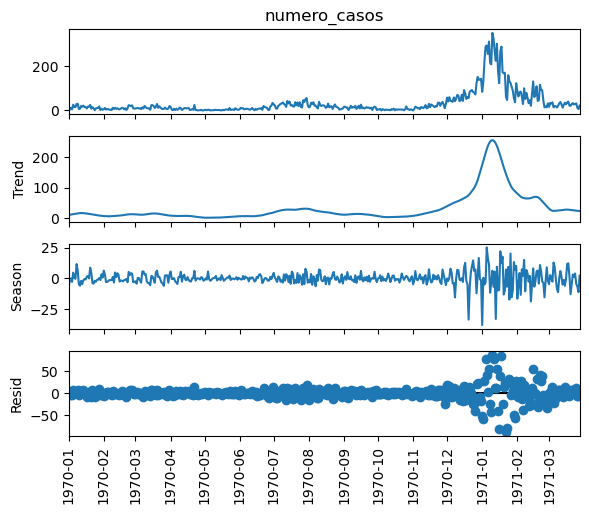

In [6]:
visualizar_STL(datos_Fuerteventura_arima_uni)

Para aplicar el modelo de ARIMA debemos de investigar los valores óptimos iniciales para los parámetros p,d,q los cuales equivalen a Autorregresivo (AR), Integrado (I), Promedio Móvil (MA). Para obtener el parámetro óptimo realizaremos diferentes estudios: 
* Para el parámetro d realizamos la prueba de Dickey-Fuller para determinar la estacionalidad de los datos de forma que si los datos son no estacionarios debemos de aplicar diferenciaciones hasta obtener una serie temporal, siendo este número de diferenciaciones el valor de d. Si la serie temporal ya era estacionaria el valor será 0.
* Para el parámetro q emplearemos la función de autocorrelación donde se estudia la correlación de los datos de la serie temporal con sus rezagos, de forma que el rezago anterior a que entre en la zona de confianza equivaldrá a nuestro parámetro óptimo.
* Para el parámetro p utilizamos la función de autocorrelación parcial que al igual que el parámetro anterior el rezago anterior a aquel que entre en la zona de confianza será el valor inicial ópti.
io.

En primer lugar realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

In [7]:
visualizar_adf(datos_Fuerteventura_arima_uni)

ADF p-value:0.06240639370244957


Realizamos una diferenciación de la serie temporal y realizamos de nuevo la prueba de Dickey-Fuller.

In [8]:
datos_Fuerteventura_arima_uni_1d = datos_Fuerteventura_arima_uni.diff().dropna()
visualizar_adf(datos_Fuerteventura_arima_uni_1d)

ADF p-value:1.2620515155267858e-05


Para la isla de Fuerteventura es necesaria una diferenciación para poder obtener una serie temporal estacionaria por lo que el parámetro d es 1.

Una vez ajustado el parámetro d realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de q.

<Figure size 1600x1000 with 0 Axes>

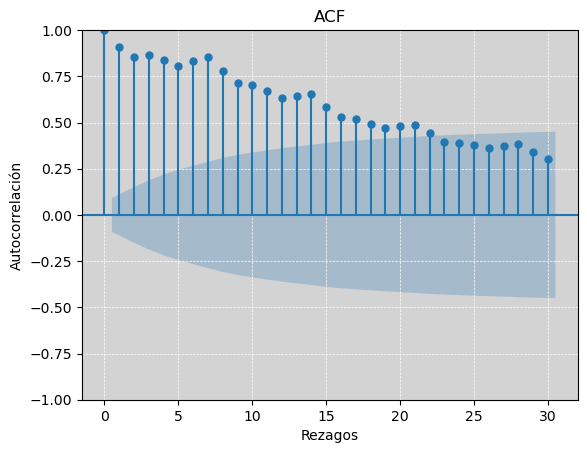

In [9]:
visualizar_acf(datos_Fuerteventura_arima_uni, 30)

Por último realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de p.

<Figure size 1600x600 with 0 Axes>

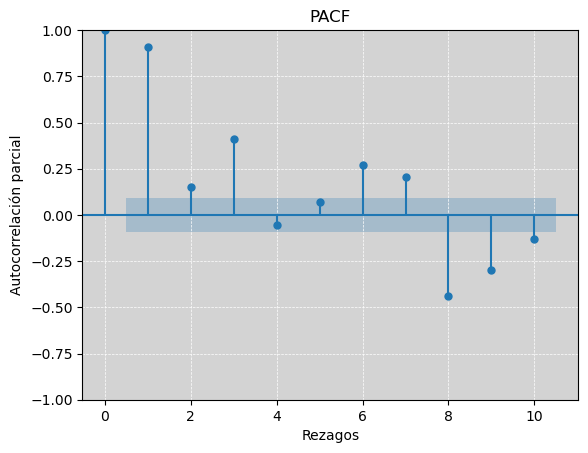

In [10]:
visualizar_pacf(datos_Fuerteventura_arima_uni, 10)

Una vez analizados los mejores valores para los parámetros realizamos pruebas con estos valores para comprobar sus resultados y posteriormente iremos modificando dichos parámetros para determinar si se ajusta mejor el algoritmo con la modificación de estos parámetros.

Tras finalizar las pruebas con diferentes valores para los parámetros, podemos determinar que los mejores resultados se obtienen con los siguientes valores de parámetro:

In [11]:
# Parámetros del modelo ARIMA
p = 6   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 3   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

Realizamos el análisis con los datos únicamente de la variable objetivo obteniendo un modelo ARIMA univariable.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [12]:
# Conjuntos de entrenamiento y test
train = datos_Fuerteventura_arima_uni.iloc[:len(datos_Fuerteventura_arima_uni) - n_dias]
test =  datos_Fuerteventura_arima_uni.iloc[len(datos_Fuerteventura_arima_uni) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [13]:
arima_Fuerteventura = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Como medida de validación del modelo visualizamos los resuldatos del criterio de información Bayesiano (BIC) y el criterio de información Akaike(AIC).

In [14]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3815.753644082916
AIC del modelo ARIMA: 3774.8631953284475


Evaluamos los residuos del modelo mediante la función de autocorrelación para determinar la correlación entre los residuos, si existe una fuerte correlación entre ellos implicaría que el modelo no está bien ajustado.

<Figure size 1600x1000 with 0 Axes>

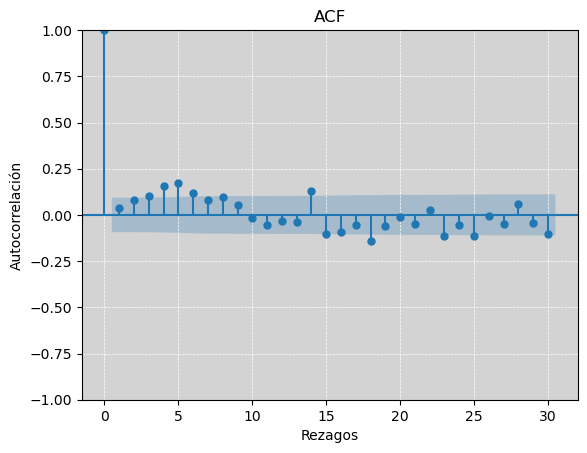

In [15]:
visualizar_acf(modelo_arima_Fuerteventura.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [16]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias)

Visualizamos una comparación entre los valores reales y los valores predichos.

In [17]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 22, número de casos predichos 28.212825646492277
2022-03-20: número de casos reales 21, número de casos predichos 19.45588416973125
2022-03-21: número de casos reales 29, número de casos predichos 27.945802406290717
2022-03-22: número de casos reales 33, número de casos predichos 33.45843950681967
2022-03-23: número de casos reales 27, número de casos predichos 29.05412623625323
2022-03-24: número de casos reales 29, número de casos predichos 31.548786818758153
2022-03-25: número de casos reales 32, número de casos predichos 35.169036250430295
2022-03-26: número de casos reales 12, número de casos predichos 29.041839282895594
2022-03-27: número de casos reales 6, número de casos predichos 24.143249868415865
2022-03-28: número de casos reales 22, número de casos predichos 29.224964355469627


Graficamos la diferencia entre los valores de test y los predichos.

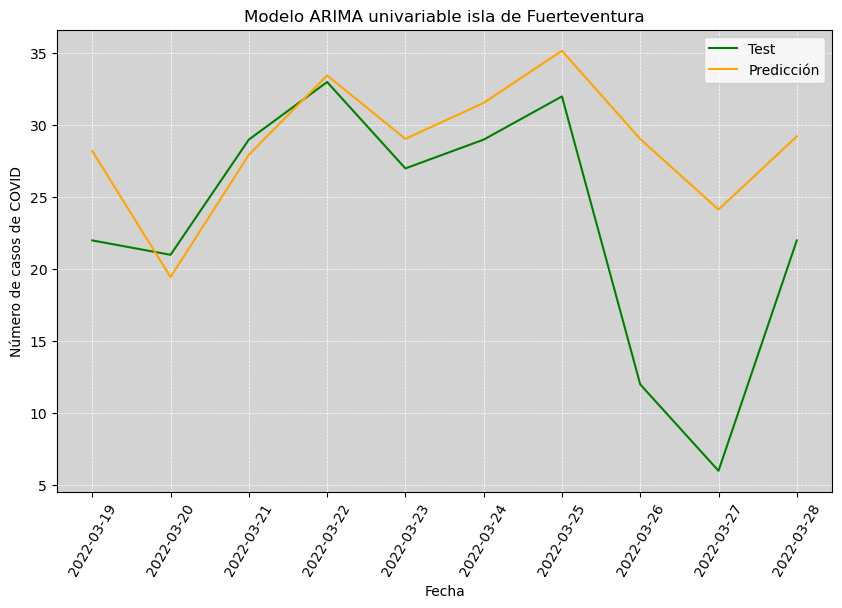

In [18]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [19]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,22,28.212826,-6.212826
2022-03-20,21,19.455884,1.544116
2022-03-21,29,27.945802,1.054198
2022-03-22,33,33.458440,-0.458440
2022-03-23,27,29.054126,-2.054126
2022-03-24,29,31.548787,-2.548787
2022-03-25,32,35.169036,-3.169036
2022-03-26,12,29.041839,-17.041839
2022-03-27,6,24.143250,-18.143250


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

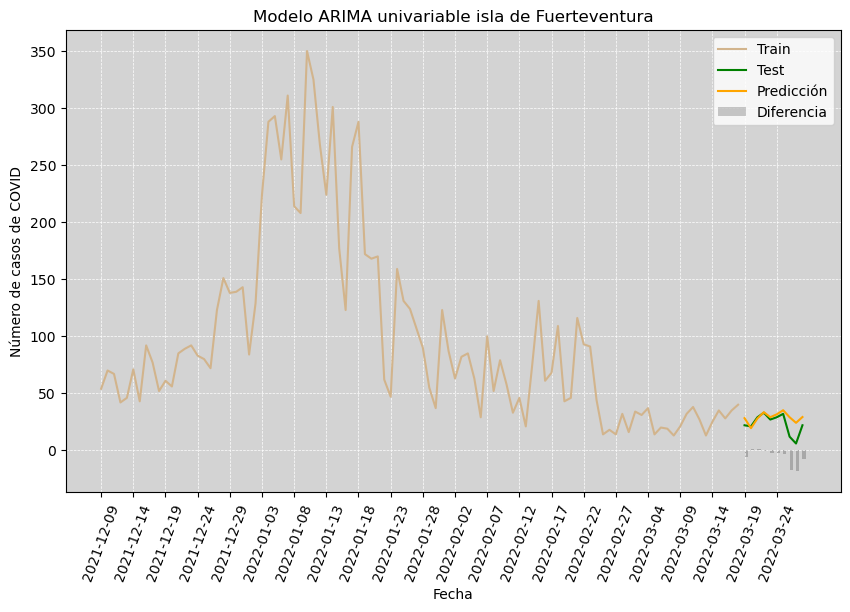

In [20]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

Para la evaluación del modelo se utilizarán las siguientes estimadores:
* MAE: Error absoluto medio
* MSE: Error cuadrático medio 
* RMSE: Raíz del error cuadrático medio 

In [21]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 73.48654470270972
Error absoluto medio (MAE) del modelo: 5.945158138951274
Raíz del error cuadrático medio (RMSE) del modelo: 8.572429334949907


# Modelo ARIMA multivariable con variables de pandemia

Realizamos el análisis con los datos pandémicos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [22]:
train = datos_Fuerteventura_arima_mult_covid.iloc[:len(datos_Fuerteventura_arima_mult_covid) - n_dias]
test =  datos_Fuerteventura_arima_mult_covid.iloc[len(datos_Fuerteventura_arima_mult_covid) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [23]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [24]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3798.998849861943
AIC del modelo ARIMA: 3741.7522216056873


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

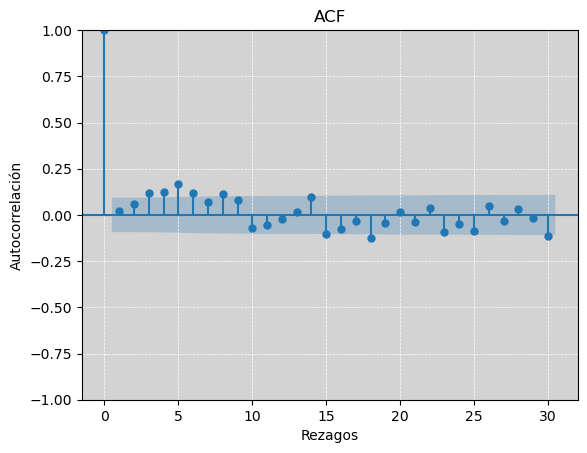

In [25]:
visualizar_acf(modelo_arima_Fuerteventura.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [26]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias, exog=test[variables_covid])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [27]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 30.636198454029024
2022-03-20: número de casos reales 21, número de casos predichos 15.211310711246938
2022-03-21: número de casos reales 29, número de casos predichos 19.631433595649675
2022-03-22: número de casos reales 33, número de casos predichos 25.59093939772678
2022-03-23: número de casos reales 27, número de casos predichos 20.198546645756004
2022-03-24: número de casos reales 29, número de casos predichos 19.125533624722912
2022-03-25: número de casos reales 32, número de casos predichos 20.09717851337065
2022-03-26: número de casos reales 12, número de casos predichos 21.185256520784776
2022-03-27: número de casos reales 6, número de casos predichos 15.824387029950714
2022-03-28: número de casos reales 22, número de casos predichos 25.873012260383266


Graficamos la diferencia entre los valores de test y los predichos.

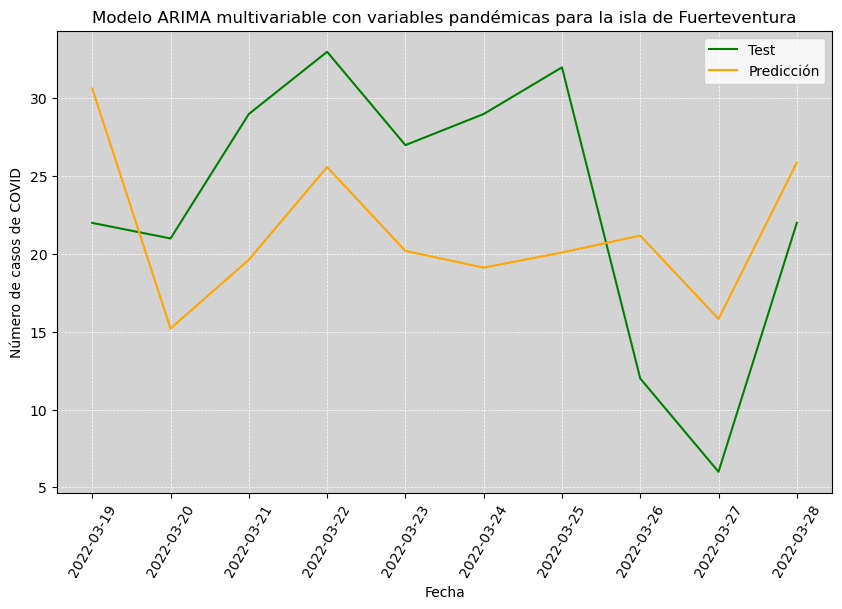

In [28]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [29]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,22,30.636198,-8.636198
2022-03-20,21,15.211311,5.788689
2022-03-21,29,19.631434,9.368566
2022-03-22,33,25.590939,7.409061
2022-03-23,27,20.198547,6.801453
2022-03-24,29,19.125534,9.874466
2022-03-25,32,20.097179,11.902821
2022-03-26,12,21.185257,-9.185257
2022-03-27,6,15.824387,-9.824387


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

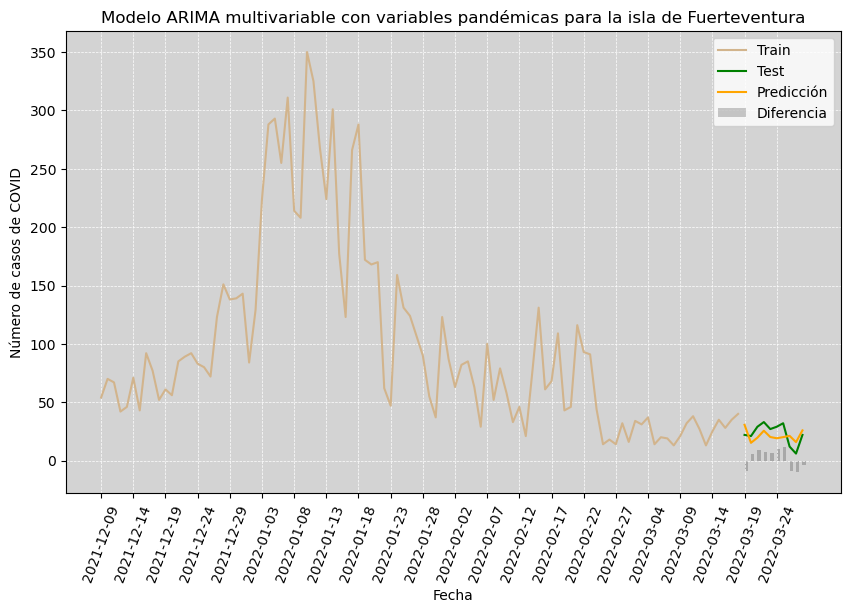

In [30]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit,color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [31]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 73.20868180049389
Error absoluto medio (MAE) del modelo: 8.266391177667483
Raíz del error cuadrático medio (RMSE) del modelo: 8.556207208833474


# Modelo ARIMA multivariable con variables atmosféricas

Realizamos el análisis con los datos atmosféricos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [32]:
train = datos_Fuerteventura_arima_mult_atm.iloc[:len(datos_Fuerteventura_arima_mult_atm) - n_dias]
test =  datos_Fuerteventura_arima_mult_atm.iloc[len(datos_Fuerteventura_arima_mult_atm) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [33]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [34]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3826.819975907565
AIC del modelo ARIMA: 3773.662392526756


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

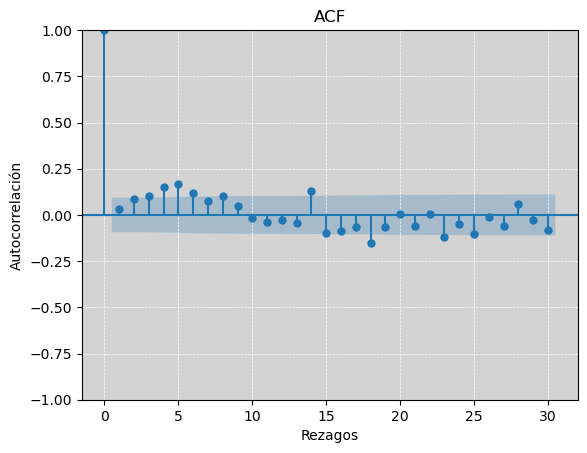

In [35]:
visualizar_acf(modelo_arima_Fuerteventura.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [36]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias, exog=test[variables_atm])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [37]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 31.622292992731523
2022-03-20: número de casos reales 21, número de casos predichos 21.23119545910527
2022-03-21: número de casos reales 29, número de casos predichos 25.65507948009921
2022-03-22: número de casos reales 33, número de casos predichos 31.927191218857118
2022-03-23: número de casos reales 27, número de casos predichos 30.570122741963836
2022-03-24: número de casos reales 29, número de casos predichos 32.343247501863466
2022-03-25: número de casos reales 32, número de casos predichos 32.0272572860403
2022-03-26: número de casos reales 12, número de casos predichos 33.58259610769842
2022-03-27: número de casos reales 6, número de casos predichos 22.35064346455465
2022-03-28: número de casos reales 22, número de casos predichos 25.318950998755206


Graficamos la diferencia entre los valores de test y los predichos.

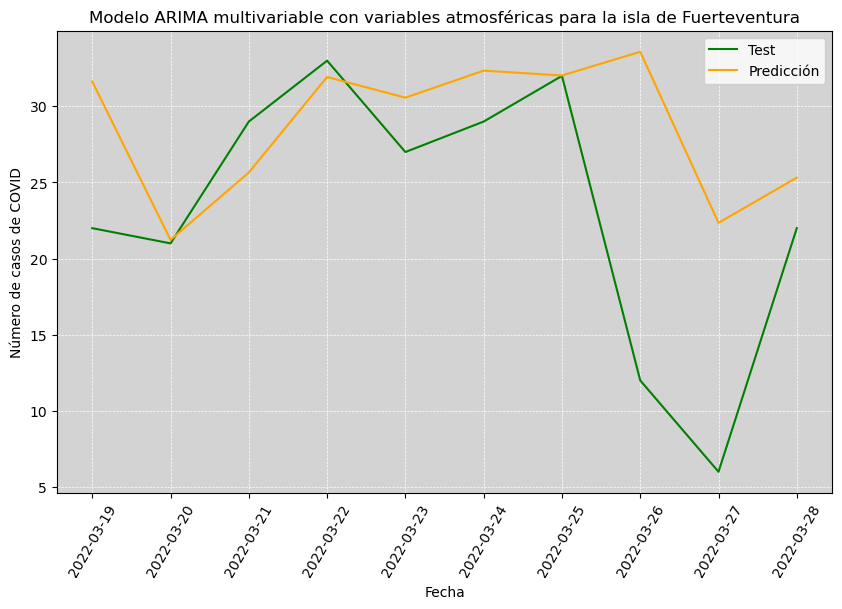

In [38]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [39]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,22,31.622293,-9.622293
2022-03-20,21,21.231195,-0.231195
2022-03-21,29,25.655079,3.344921
2022-03-22,33,31.927191,1.072809
2022-03-23,27,30.570123,-3.570123
2022-03-24,29,32.343248,-3.343248
2022-03-25,32,32.027257,-0.027257
2022-03-26,12,33.582596,-21.582596
2022-03-27,6,22.350643,-16.350643


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

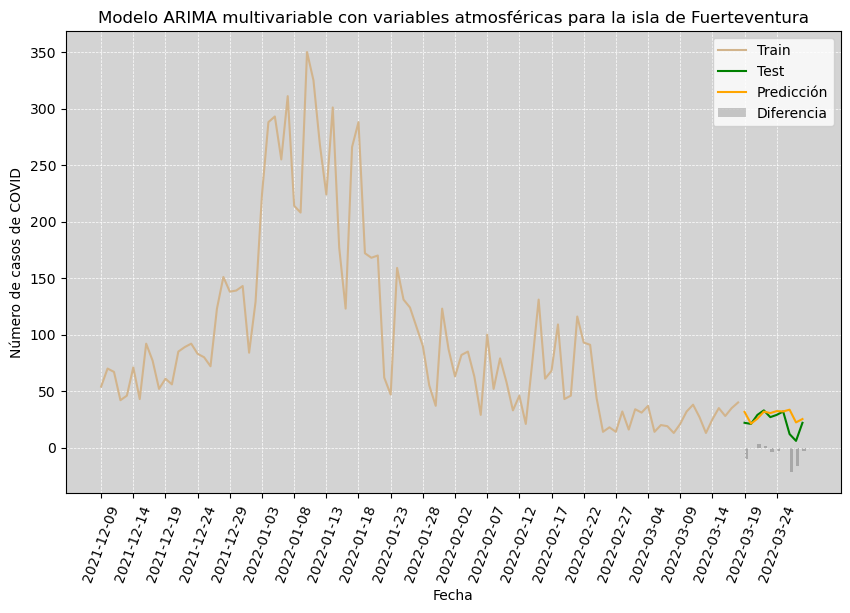

In [40]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [41]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 87.30726411398385
Error absoluto medio (MAE) del modelo: 6.246403585375635
Raíz del error cuadrático medio (RMSE) del modelo: 9.343835621091793


# Modelo ARIMA multivariable con todas las variables

Realizamos el análisis unificando los datos tanto pandémicos como atmosféricos.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [42]:
train = datos_Fuerteventura_arima_total.iloc[:len(datos_Fuerteventura_arima_total) - n_dias]
test =  datos_Fuerteventura_arima_total.iloc[len(datos_Fuerteventura_arima_total) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [43]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [44]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3835.86190920885
AIC del modelo ARIMA: 3766.3481463262538


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

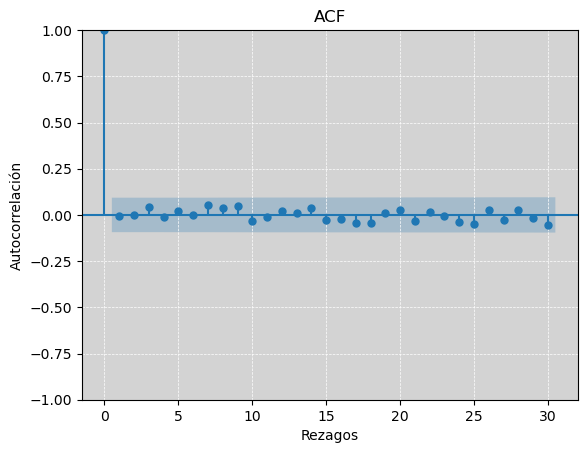

In [45]:
visualizar_acf(modelo_arima_Fuerteventura.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [46]:
pred = modelo_arima_Fuerteventura.forecast(steps=10, exog=test[variables])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [47]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 28.91299759705157
2022-03-20: número de casos reales 21, número de casos predichos 20.273600651934316
2022-03-21: número de casos reales 29, número de casos predichos 24.99054564692949
2022-03-22: número de casos reales 33, número de casos predichos 25.621323190218845
2022-03-23: número de casos reales 27, número de casos predichos 20.405286387821207
2022-03-24: número de casos reales 29, número de casos predichos 18.97790603341366
2022-03-25: número de casos reales 32, número de casos predichos 16.23694614235842
2022-03-26: número de casos reales 12, número de casos predichos 20.638433672949418
2022-03-27: número de casos reales 6, número de casos predichos 13.26037466121511
2022-03-28: número de casos reales 22, número de casos predichos 24.773391322705606


Graficamos la diferencia entre los valores de test y los predichos.

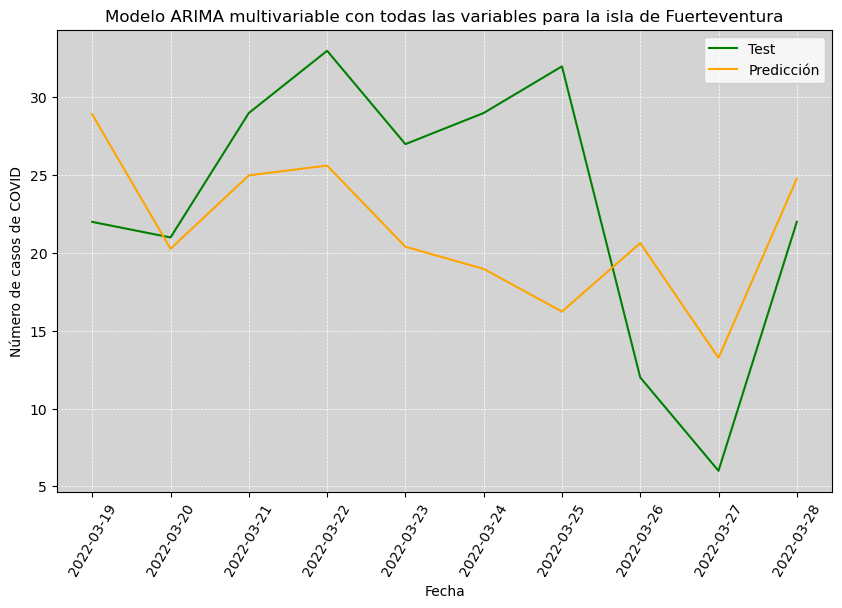

In [48]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [49]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,22,28.912998,-6.912998
2022-03-20,21,20.273601,0.726399
2022-03-21,29,24.990546,4.009454
2022-03-22,33,25.621323,7.378677
2022-03-23,27,20.405286,6.594714
2022-03-24,29,18.977906,10.022094
2022-03-25,32,16.236946,15.763054
2022-03-26,12,20.638434,-8.638434
2022-03-27,6,13.260375,-7.260375


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

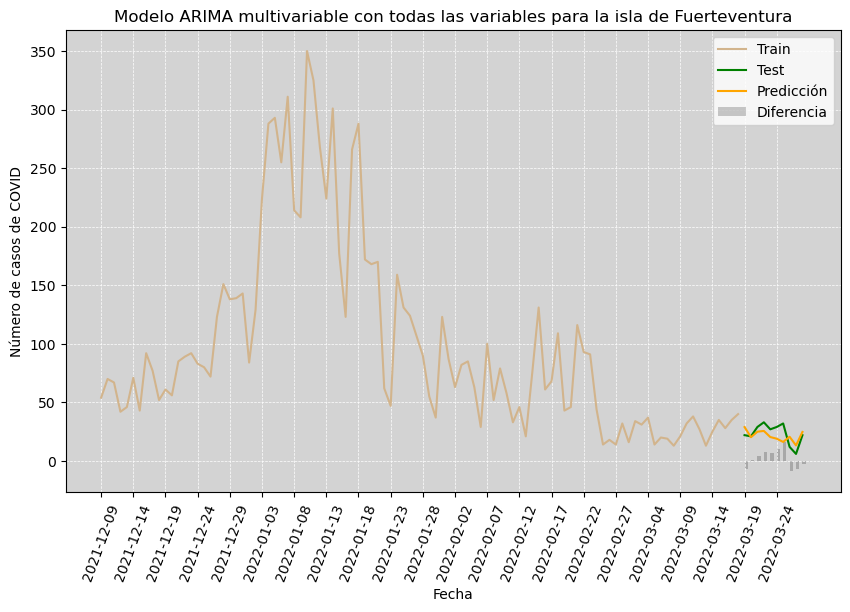

In [50]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [51]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 64.62715454549407
Error absoluto medio (MAE) del modelo: 7.007958920124577
Raíz del error cuadrático medio (RMSE) del modelo: 8.039101600645067
